In [14]:
# 导入需要的模块
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data 
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import STL10
import hiddenlayer as hl
from torch.utils.tensorboard import SummaryWriter

In [15]:
## 加载数据

## 定义一个将bin文件处理为图像数据的函数
def read_image(data_path):
    with open(data_path,'rb') as f:

        data1 = np.fromfile(f,dtype=np.uint8)

        # 将图像数据  reshape成 [数量，通道数  宽 高]
        images = np.reshape(data1,(-1,3,96,96))

        # 将图像转换成RGB格式 第一维是图像的数量 后面的三维表示图像的RGB像素值
        images = np.transpose(images,(0,3,2,1))


    # 归一化操作 将输出的图像取值在 0 1 之间
    return images / 255.0


In [16]:
#  通过read_image 读取stl10数据
data_path = "/home/xxf/work/DeepLearning/code/stl10/stl10_binary/train_X.bin"
images = read_image(data_path)
print("images.shape:",images.shape)  # 5000 x  96 x 96 x 3的图像  3 表示通道数

images.shape: (5000, 96, 96, 3)


In [17]:
## 定义一个为图像数据添加高斯噪声的函数  添加随机噪声
def gaussian_noise(images, sigma):
    """sigma: 噪声标准差"""
    sigma2 = sigma**2 / (255 ** 2)   # 噪声方差
    images_noisy = np.zeros_like(images)
    for ii in range(images.shape[0]):
        image = images[ii]
        # 使用skimage中的函数增加噪音
        noise_im = random_noise(image, mode="gaussian", var=sigma2, clip=True)
        images_noisy[ii] = noise_im
    return images_noisy

images_noise = gaussian_noise(images, 30)
print("image_noise:", images_noise.min(), "~", images_noise.max())

image_noise: 0.0 ~ 1.0


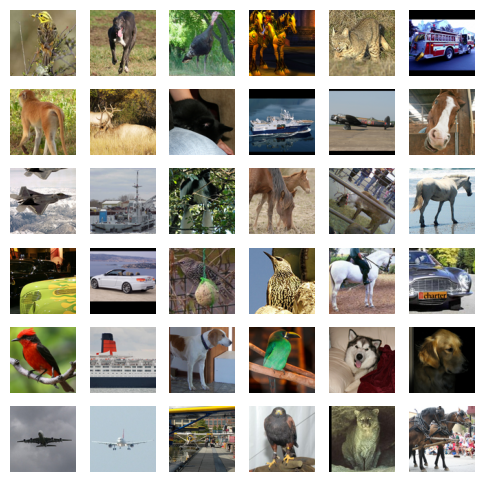

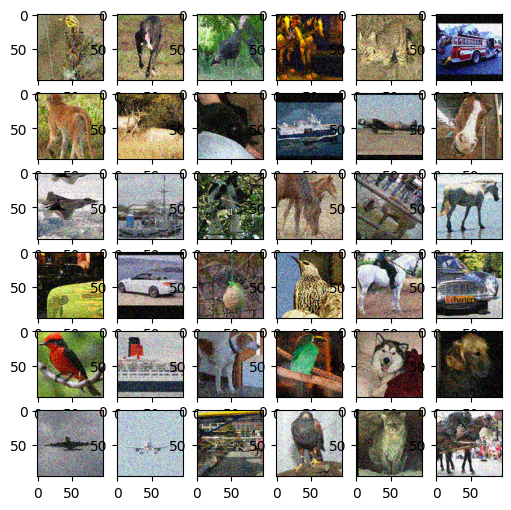

In [18]:
#  不带噪声的图片
plt.figure(figsize=[6, 6])
for ii in np.arange(36):
    plt.subplot(6, 6, ii + 1)
    plt.imshow(images[ii, ...])
    plt.axis("off")
plt.show()

# 带噪音的图片
plt.figure(figsize=[6, 6])
for ii in np.arange(36):
    plt.subplot(6, 6, ii + 1)
    plt.imshow(images_noise[ii, ...])
plt.show()

In [19]:
# 将数据集切分成  训练集和验证集 并转换成tensor张量
data_Y = np.transpose(images,(0,3,2,1))  # 转换成  数量 x 通道 x 高 x 宽 的数据形式
data_X = np.transpose(images_noise,(0,3,2,1))  # 转换成  数量 x 通道 x 高 x 宽 的数据形式

#  将数据集转换成 训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(data_X,data_Y,test_size=0.2,random_state= 123)

# 将图像数据转换为tensor
X_train = torch.tensor(X_train,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
X_val = torch.tensor(X_val,dtype=torch.float32)
y_val = torch.tensor(y_val,dtype=torch.float32)

# 将 X Y转换成 数据集合  
train_data = Data.TensorDataset(X_train,y_train)
val_data = Data.TensorDataset(X_val,y_val)


print("X_train.shape:",X_train.shape)
print("X_train.shape:",y_train.shape)
print("X_train.shape:",X_val.shape)
print("X_train.shape:",y_val.shape)

X_train.shape: torch.Size([4000, 3, 96, 96])
X_train.shape: torch.Size([4000, 3, 96, 96])
X_train.shape: torch.Size([1000, 3, 96, 96])
X_train.shape: torch.Size([1000, 3, 96, 96])


In [20]:
# 定义一个数据加载器

train_loader = Data.DataLoader(
    dataset=train_data,  ## 使用的数据集
    batch_size=32,## 批处理样本大小
    shuffle=True, ## 每次迭代前 打乱数据
    num_workers=4, ## 使用四个进程
)

val_loader = Data.DataLoader(
    dataset=val_data,  ## 使用的数据集
    batch_size=32,## 批处理样本大小
    shuffle=True, ## 每次迭代前 打乱数据
    num_workers=4, ## 使用四个进程
)

In [21]:
class DenoiseAutoENcoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoENcoder,self).__init__()

        # 定义Encoder
        self.Encoder = nn.Sequential(

            # 3 x 96 x 96 -> 64 x 96 x 96 
           nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1) ,
           nn.ReLU(), # 激活函数
           nn.BatchNorm2d(64),
           
           nn.Conv2d(64,64,3,1,1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.BatchNorm2d(64),
           nn.Conv2d(64,64,3,1,1),
           nn.ReLU(),
           nn.BatchNorm2d(64),
           nn.Conv2d(64, 128, 3, 1, 1), # [, 128, 48, 48]
           nn.ReLU(),
           nn.BatchNorm2d(128),
           nn.Conv2d(128, 128, 3, 1, 1), # [, 128, 48, 48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3,1,1),
            nn.ReLU(),
            # 256 x 24 x 24   256个通道  24 x 24 图片大小
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(256)
        )
        #  定义decoder

        self.Decoder = nn.Sequential(
            # 256 x 24 x 24 -> 128 x 24 x 24  转置卷积  放大特征映射
            nn.ConvTranspose2d(256,128,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128,128,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 3, 1, 1),    # [, 64, 48, 48]
            nn.ReLU(),
            nn.BatchNorm2d(64),


            nn.ConvTranspose2d(64,32,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32,32,3,1,1),
            nn.ConvTranspose2d(32,16,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,3,1,1),
            nn.Sigmoid()

        )

    def forward(self,x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder,decoder
    



In [22]:
DAEmodel = DenoiseAutoENcoder()
 # 输出网络结构
from torchviz import make_dot
x = torch.randn(1,3,96,96).requires_grad_(True)  # 模拟输入
_,y = DAEmodel(x)

vis_net = make_dot(y, params=dict(list(DAEmodel.named_parameters()) + [("x", x)]))
vis_net.view()

'Digraph.gv.pdf'

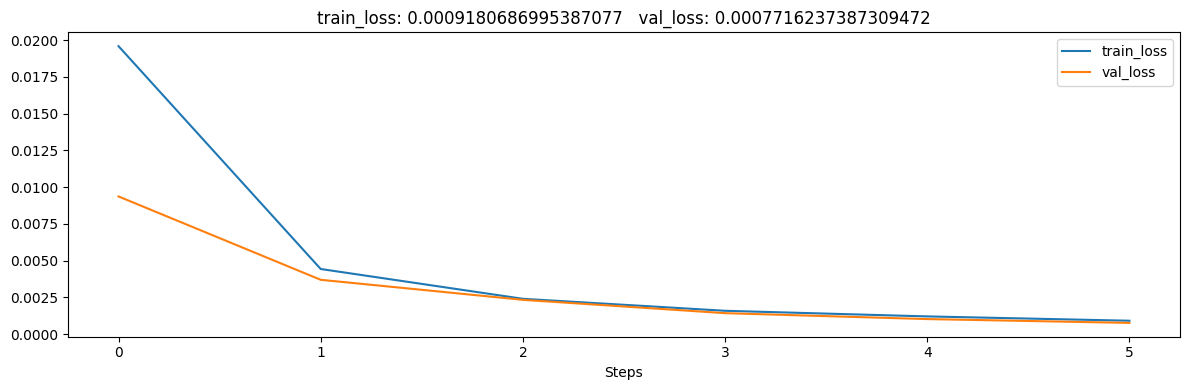

In [23]:
# 训练和预测
LR = 0.0003
optimizer = optim.Adam(DAEmodel.parameters(),lr = LR) # 定义优化器
loss_func = nn.MSELoss() # 损失函数

history = hl.History()
canvas = hl.Canvas()

train_num,val_num = 0,0

total_train_step = 0  # 训练次数

writer = SummaryWriter("../encoder_image_noise")

for epoch in range(6):
    train_loss_epoch,val_loss_epoch = 0,-0

    # 训练
    for step,(b_x,b_y) in enumerate(train_loader):
        DAEmodel.train()
        
        _,output = DAEmodel(b_x)
        loss = loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        
        # 优化
        optimizer.step()

        # 迭代损失  一个epoch的损失
        train_loss_epoch += loss.item() * b_x.size(0)

        # 训练次数
        train_num += b_x.size(0)

        # 统计训练次数
        total_train_step = total_train_step + 1

        if total_train_step % 100 == 0:
            # 绘制训练损失
            writer.add_scalar("train_image_loss",loss.item(),total_train_step)
            print("训练次数:{},Loss{}".format(total_train_step,loss.item()))

    # 验证集
    for step,(b_x,b_y) in enumerate(val_loader):
        DAEmodel.eval()
        _,output = DAEmodel(b_x)
        loss = loss_func(output,b_y)
        val_loss_epoch += loss.item() * b_x.size(0)
        val_num += b_x.size(0)

    
    # 计算一个epoch的损失
    train_loss = train_loss_epoch / train_num
    print("训练损失是{}".format(train_loss))
    val_loss = val_loss_epoch / val_num
    print("验证集损失是{}".format(val_loss))

    

    # 记录hiddenlayer的记录并动态可视化训练过程
    history.log(epoch, train_loss = train_loss, val_loss = val_loss)
    with canvas:
        canvas.draw_plot([
            history["train_loss"],
            history["val_loss"]
        ])
